## Imports

In [15]:
import numpy as np
import pandas as pd

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from collections import Counter

import optuna

## Test-Dataset generieren

Siehe https://machinelearningmastery.com/one-class-classification-algorithms/

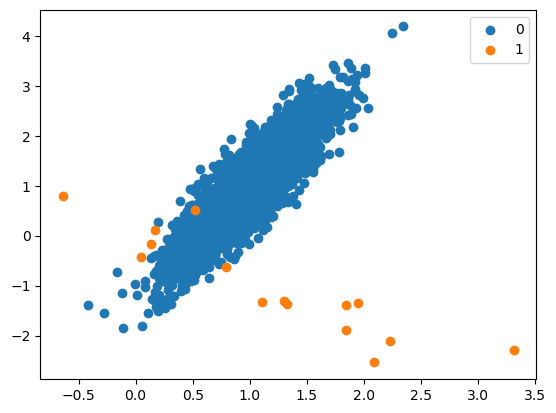

In [16]:
# define dataset
X, y = make_classification(n_samples=5000, n_features=2, n_redundant=0,
 n_clusters_per_class=1, weights=[0.997], flip_y=0, random_state=3)

X = pd.DataFrame(X)
y = pd.Series(y)

# scatter plot of examples by class label
for label in y.unique():
 row_ix = y[y == label].index
 plt.scatter(X.loc[row_ix, 0], X.loc[row_ix, 1], label=str(label))
plt.legend()
plt.show()

## Daten aufteilen und vorbereiten

Das Trainings-Set besteht nur aus guten Datenpunkten. Test- und Validation-Set bestehen aus guten und schlechten Datenpunkten.  
Danach werden die Daten noch mit einem `StandardScaler` skaliert.  

Anmerkung: Der Split der guten Datenpunkte ist hier kein perfekter 80:10:10-Split.  
Den könnte man aber wenn nötig vielleicht machen, indem man den Dataframe shuffled (`df.sample(frac=1)`) und dann "von oben" jeweils 2 * 10% der Datenpunkte nimmt. (ungetestet)

In [17]:
X_good_only = X[y==0]
X_bad_only = X[y==1]

# 10% of good data points go into test set, 10% of good training data points go into validation set
X_train, X_test = train_test_split(X_good_only, test_size=0.1, random_state=42)
X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=42)

y_train = y[X_train.index]
y_valid = y[X_valid.index]
y_test = y[X_test.index]

# 50% of bad data points go into test set, 50% of bad data points go into validation set
X_bad_test, X_bad_valid = train_test_split(X_bad_only, test_size=0.5, random_state=42)

y_bad_test = y[X_bad_test.index]
y_bad_valid = y[X_bad_valid.index]

X_test = pd.concat([X_test, X_bad_test])
y_test = pd.concat([y_test, y_bad_test])

X_valid = pd.concat([X_valid, X_bad_valid])
y_valid = pd.concat([y_valid, y_bad_valid])

# Scale data
scaler = StandardScaler()
# Edit (11.12.2024): Hier war ein Fehler, dass die X gar nicht neu gesetzt werden. Und Index und Spalten werden jetzt mitgezogen.
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns) # Fit only on training data
X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

Checken, ob die Verteilung passt.  
Die Indizes zwischen X_train, X_valid, X_test und y_train, y_valid, y_test müssen und sollten auch gleich sein.

In [18]:
y_train.value_counts()

0    4037
dtype: int64

In [19]:
y_test.value_counts()

0    499
1      7
dtype: int64

In [20]:
y_valid.value_counts()

0    449
1      8
dtype: int64

## OneClassSVM trainieren und Hyperparameter mit Optuna optimieren

Hier **ohne** Cross-Validation, weil das die Verteilung der guten und schlechten Datenpunkte auf die Sets kompliziert macht. Geht aber bestimmt auch irgendwie und wäre sinnvoll.

In [21]:
# The function to be optimized
def objective(trial):

    # Ranges for the parameters of the OneClassSVM (see sklearn documentation for details)

    param = {
        "kernel" : trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
        "tol" : trial.suggest_float("tol", 1e-3, 1.0, log=True),
        "nu" : trial.suggest_float("nu", 1e-3, 1.0, log=True)
    }

    if param["kernel"] in ["rbf", "poly", "sigmoid"]:
        param["gamma"] = trial.suggest_float("gamma", 1e-3, 1.0, log=True)

    if param["kernel"] in ["poly", "sigmoid"]:
        param["coef0"] = trial.suggest_float("coef0", 1e-3, 10.0, log=True)

    if param["kernel"] == "poly":
        param["degree"] = trial.suggest_int("degree", 1, 8)

    # Train OneClassSVM
    oc_svm_clf = OneClassSVM(**param)
    oc_svm_clf.fit(X_train)

    # Predict on validation set
    y_pred = oc_svm_clf.predict(X_valid)
    y_pred_labels = pd.Series(y_pred).apply(lambda y: 1 if y == -1 else 0) # Output from OneClassSVM: -1 = Bad, 1 = Good

    # Return a score (here: F1 score = geometric mean of precision and recall)
    return f1_score(y_valid, y_pred_labels)

In [22]:
# Run optimization
study = optuna.create_study(direction="maximize")
# Run 100 iterations, use all available CPU cores
study.optimize(objective, n_trials=100, n_jobs=-1) 

[I 2023-12-11 13:08:31,436] A new study created in memory with name: no-name-da8acd67-dfd8-40e6-87f1-1a82da495686
[I 2023-12-11 13:08:31,492] Trial 3 finished with value: 0.8571428571428571 and parameters: {'kernel': 'rbf', 'tol': 0.0016380751187526031, 'nu': 0.0031604691056200365, 'gamma': 0.3072173058895236}. Best is trial 3 with value: 0.8571428571428571.
[I 2023-12-11 13:08:31,510] Trial 1 finished with value: 0.5555555555555556 and parameters: {'kernel': 'rbf', 'tol': 0.018133236749830844, 'nu': 0.020398306456337174, 'gamma': 0.0013261072802886265}. Best is trial 3 with value: 0.8571428571428571.
[I 2023-12-11 13:08:31,522] Trial 2 finished with value: 0.052631578947368425 and parameters: {'kernel': 'linear', 'tol': 0.009036965715449007, 'nu': 0.0866615812302252}. Best is trial 3 with value: 0.8571428571428571.
[I 2023-12-11 13:08:31,538] Trial 7 finished with value: 0.15384615384615385 and parameters: {'kernel': 'sigmoid', 'tol': 0.007318363191625602, 'nu': 0.007840171630055726, 

## Bestes Modell auf allen Daten evaluieren

In [23]:
params = study.best_params

oc_svm_clf = OneClassSVM(**params)
oc_svm_clf.fit(X_train)

y_pred = oc_svm_clf.predict(X_test)
y_pred_labels = pd.Series(y_pred).apply(lambda y: 1 if y == -1 else 0) # Output from OneClassSVM: -1 = Bad, 1 = Good

print(f1_score(y_test, y_pred_labels))

0.8571428571428571


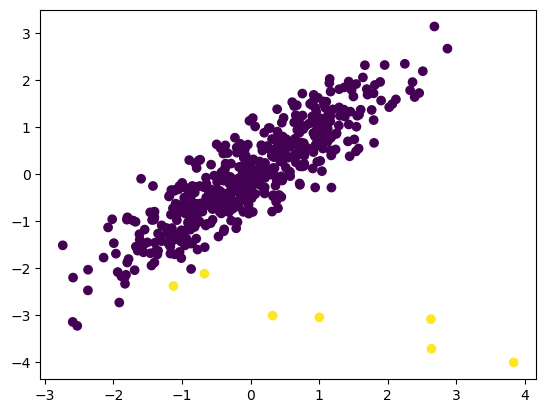

In [24]:
# Plot test data points and mark those classified as bad
plt.scatter(X_test[0], X_test[1], c=y_pred_labels)
plt.show()